# Training VQA Models with BP Mitigation Strategies: Method 0
*Training QNN treated with method 0 (General) of the BP mitigation strategy (Cancer)*<br/>
*Compatible with Qiskit V1.02+*

### Authors
- **Thanh Nguyen**, nnct2000[at]gmail.com<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Date
- Jul 2022: Prepared for Tim's Hons thesis
- Feb 2023: Reimplemented for the paper by Jacob L. Cybulski and Thanh Nguyen (2023): "Impact of Barren Plateaus Countermeasures on the Quantum Neural Network Capacity to Learn." *Quantum Information Processing*, 22, 442.
- May 2024: Compatibility upgrade to Qiskit 1.02 

In [1]:
import os
import numpy as np
import pylab
import math
import json
import time
import warnings
import pandas as pd
import copy, math

from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

In [2]:
### Libraries used in BPMS development

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, SPSA, QNSPSA, ADAM, UMDA
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit import Parameter
from qiskit.compiler import transpile


from sklearn.datasets import make_moons, make_circles, make_blobs, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn

from Components.train import *
from Components.data import cancer_data, fetch_mnist, fetch_mnist_balanced
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

In [3]:
from os.path import exists
from os import makedirs

In [4]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm0'

In [5]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
# estimator = Estimator()

In [6]:
# X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
X_train, X_val, y_train, y_val = fetch_mnist_balanced(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 70 samples
Testing set: 30 samples
Number of features: 4
Classes:[0 1]; Encoded as: [-1  1]
Training labels 1 ("1"): 35, -1 ("0"): 35
Test labels 1 ("1"): 15, -1 ("0"): 15


In [7]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
else:
    makedirs(f'{LOG_PATH}/{METHOD_TAG}')
    print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-MNIST-100/m0



## Measuring Gradient Variance Decay

In [8]:
# Only use in the fist phase

num_qubits = list(range(2, MAX_QUBITS))

# Globak operator for all ansatzes, measure all qubits
G_O = [SparsePauliOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 last qubits
L_O = [SparsePauliOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [9]:
reps = num_qubits
ansatzes_m0 = [AnsatzGenerator(n, r) for n, r in zip(num_qubits, reps)]

In [10]:
def sampleM0Var():
    gradients_m0 = sampleAnsatz(estimator, ansatzes_m0, G_O)
    variance = getVariance(gradients_m0, num_qubits)
    return variance

## Loss Function Surface

In [11]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
print(f'Available devices: {devices}')

# Force CPU - PyTorch+Qiskit too slow with GPU
devices = ('CPU')
print(f'Device to be used: {devices}')

Available devices: ('CPU', 'GPU')
Device to be used: CPU


In [12]:
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Estimator as AerEstimator # For device="GPU" option

seed = 2023

device = 'CPU' # Torch and qiskit are slow on GPU
estimator = AerEstimator(
    backend_options={'seed_simulator': seed, 'method': 'statevector', 
                     'device' : device, 'cuStateVec_enable' : True},
    run_options={'seed': seed, 'shots': 1000},
    transpile_options={"seed_transpiler": seed},
)

print(f'Selected device: {device}')

Selected device: CPU


### Test ansatz and surface properties

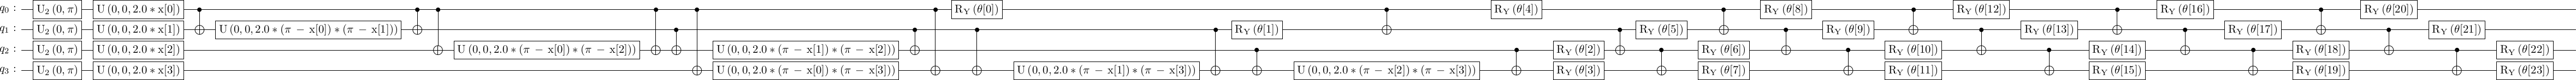

In [13]:
# Create a circuit
# an_qs = MAX_QUBITS_CLASSIFICATION; an_reps=MAX_REPS_CLASSIFICATION
an_qs = 4; an_reps=5
fm = featureMapGenerator(FEATURE_DIM)
an = AnsatzGenerator(an_qs, an_reps, ENTANGLEMENT)
circ = circuitBuilder(fm, an)
display(circ.decompose().decompose().draw(output="latex", style="iqp"))

# Create a QNN
# loss_function = nn.L1Loss() #This is MAE loss
# loss_function = nn.MSELoss()
# loss_function = nn.SmoothL1Loss()
# loss_function = nn.SoftMarginLoss()
# loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()
# paulis = SparsePauliOp.from_list([('Z'+'I'*(an_qs-1), 1)])
paulis = SparsePauliOp.from_list([('Z'*an_qs, 1)])
qnn = EstimatorQNN(
    circuit=circ,
    estimator=estimator,
    observables=paulis,
    input_params=fm.parameters,
    weight_params=an.parameters,
    input_gradients=True
)

# Create a Torch model
point = [n/an.num_parameters-0.5 for n in range(an.num_parameters)]
model = TorchConnector(qnn, initial_weights=point)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

# zero the parameter gradients
optimizer.zero_grad()
outp = model(X_train_t)
res_loss = loss_function(outp.flatten(), y_train_t)

# log result
loss = res_loss.detach().flatten()[0]
weight = copy.deepcopy(model.weight.data)

In [14]:
print(f'Number of ansatz parameters: {an.num_parameters}')
print(f'Number of resulting weights: {len(weight)}')
# print(f'Initial point: {[np.round(n, 3) for n in point]}')
# print(f'Resulting weights: {[np.round(n, 3) for n in weight.detach().flatten().numpy()]}')
print(f'Resulting loss: {np.round(loss, 3)}')
print(f'Results mean: {np.mean(outp.detach().flatten().numpy())}')
print(f'Results var: {np.var(outp.detach().flatten().numpy())}')
# print(y_train_t)
print(np.round(outp.detach().flatten().numpy(), 3))

Number of ansatz parameters: 24
Number of resulting weights: 24
Resulting loss: -2.385999917984009
Results mean: 0.014028572477400303
Results var: 0.012808055616915226
[ 0.026  0.09   0.09   0.036  0.024  0.006  0.09   0.14   0.062  0.112
 -0.2    0.132  0.144 -0.086 -0.162 -0.018 -0.06   0.042 -0.088 -0.226
  0.06   0.08  -0.072 -0.096  0.152 -0.22  -0.176  0.136 -0.044 -0.172
  0.212  0.2   -0.236 -0.026 -0.076  0.126 -0.056  0.07  -0.044  0.142
  0.094  0.102  0.006  0.058  0.046  0.102  0.058 -0.022 -0.012  0.062
  0.062  0.048  0.038 -0.144 -0.222  0.11   0.166  0.188  0.026 -0.066
  0.15   0.016 -0.05  -0.032  0.2    0.062  0.054 -0.11  -0.124  0.002]


### Create a surface

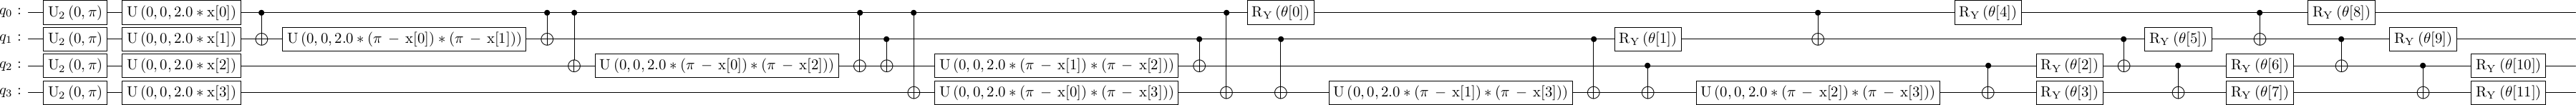

Number of features: 4
Number of qubits: 4
Number of inputs: 4
Number of weights: 12


In [17]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MAX_REPS_CLASSIFICATION, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)
initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
display(qc.decompose().decompose().draw(output="latex", style="iqp"))
print(f'Number of features: {FEATURE_DIM}')
print(f'Number of qubits: {qc.num_qubits}')
print(f'Number of inputs: {feature_map.num_parameters}')
print(f'Number of weights: {ansatz.num_parameters}')

In [18]:
gen_surface = True

epochs = 200
elapsed = 0
res = pd.DataFrame()

if gen_surface:
    
    # loss_function = nn.L1Loss() #This is MAE loss
    # loss_function = nn.MSELoss()
    # loss_function = nn.SmoothL1Loss()
    # loss_function = nn.SoftMarginLoss()
    # loss_function = nn.BCEWithLogitsLoss()
    loss_function = nn.CrossEntropyLoss()
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True
    )
    
    start = time.time()
    for i in range(0, epochs):
        print('iteration: ', i)
        display(res.tail())
        
        point = np.random.uniform(-np.pi*2, np.pi*2, ansatz.num_parameters)
        model = TorchConnector(qnn, initial_weights=point)
        optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)
    
        loss, weight = sampleWeightLoss(
            model, 
            X_train_t,
            y_train_t,
            optimizer = optimizer, 
            loss_function = loss_function,
            # accuracy_fun = accuracy_score
            )
        res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss)).transpose()], ignore_index=True) 
        clear_output(wait=True)
    elapsed = time.time() - start
    
    pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

iteration:  199


,0,1,2,3,4,5,6,7,8,9,10,11,12
194,-1.647857,-3.153512,-3.384995,1.739634,-4.524312,3.470264,2.433407,-2.587454,4.471607,-4.197117,-3.909660,-6.029601,4.817998
195,-5.623139,-5.531752,-4.576468,3.912478,0.686761,6.051595,-2.345632,-5.957748,5.051985,3.830113,-3.632030,-2.030057,-0.099995
196,1.041870,6.190036,-0.723664,-1.609088,-0.517444,4.055979,3.425145,-1.835517,3.056629,2.177273,4.753487,-2.619662,-0.266000
197,3.526322,-3.329742,-1.358639,-3.101075,5.482607,0.338921,5.981363,-3.188732,-6.203700,5.385050,-5.649116,-4.575916,1.975999
198,2.139002,-1.222426,-1.771030,-4.968880,3.628542,-0.197583,-0.546242,-4.710567,-1.614666,6.265186,-5.411216,0.694130,5.380005


In [19]:
# Print run statistics
print(f'{device} Fit\n'+
      f'\tQubits:\t\t{num_qubits}\n'+
      f'\tReps:\t\t{reps}\n'+
      f'\tWeights:\t{len(ansatz.parameters)}\n'+
      f'\tEpochs:\t\t{epochs}\n'+
      f'\tTime:\t\t{elapsed:0.2f} sec\n'+
      f'\tMin Loss:\t{np.round(float(res.iloc[:,-1:].min().iloc[0] if len(res.columns) != 0 else 0), 4)}')

CPU Fit
	Qubits:		[2, 3, 4, 5]
	Reps:		[2, 3, 4, 5]
	Weights:	12
	Epochs:		200
	Time:		17.07 sec
	Min Loss:	-9.228


## Measure Training Performance

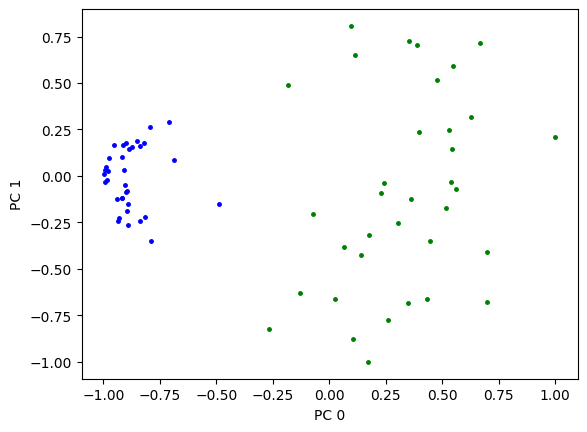

Blue: torch.Size([35])
Green: torch.Size([35])


In [20]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

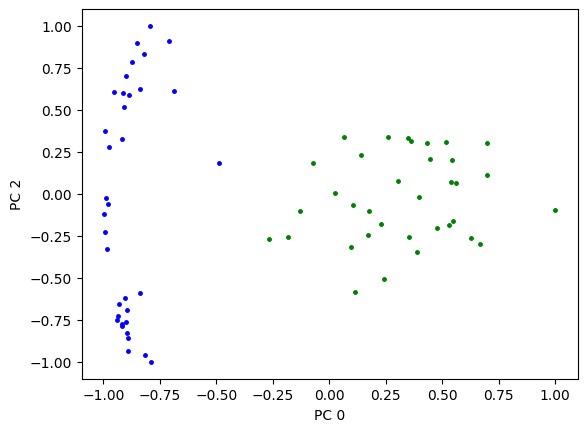

Blue: torch.Size([35])
Green: torch.Size([35])


In [21]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

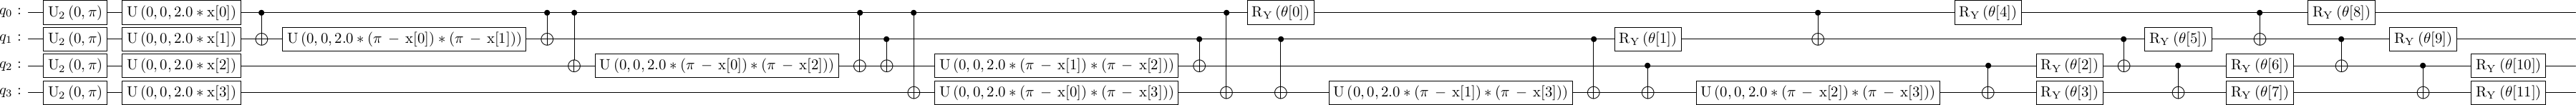

In [22]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MAX_REPS_CLASSIFICATION, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)
qc.decompose().decompose().draw(output="latex", style="iqp")

In [23]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH
times = []

# loss_function = nn.L1Loss() #This is MAE loss
# loss_function = nn.MSELoss()
# loss_function = nn.SmoothL1Loss()
# loss_function = nn.SoftMarginLoss()
# loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()

qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    observables=GLOBAL_OPERATOR,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True
)

In [ ]:
# for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
for i in [0]: 
     
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')

    m0_variances = sampleM0Var()
    # init_point = np.random.uniform(-np.pi*2, np.pi*2, ansatz.num_parameters)
    # model = TorchConnector(qnn, initial_weights=init_point)
    model = TorchConnector(qnn)
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    start = time.time()
    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    elapsed = time.time() - start
    times.append(elapsed)

    pd.DataFrame(m0_variances, num_qubits).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Variances.csv')
    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)


Adding a new instance 0 of method m0

Number of ansatzes, parameters, operator to run: 400
Epoch      Loss                 Train Accuracy   Test Accuracy   
[ 0 ]      -2.4040000438690186  0.58571          0.4             
[ 10 ]     -10.663999557495117  0.77143          0.73333         
[ 20 ]     -17.281999588012695  0.85714          0.76667         
[ 30 ]     -18.1200008392334    0.85714          0.83333         


In [28]:
print(f'\nAverage time / instance: {np.average(times)} secs')


Average time / instance: 8222.500973701477 secs


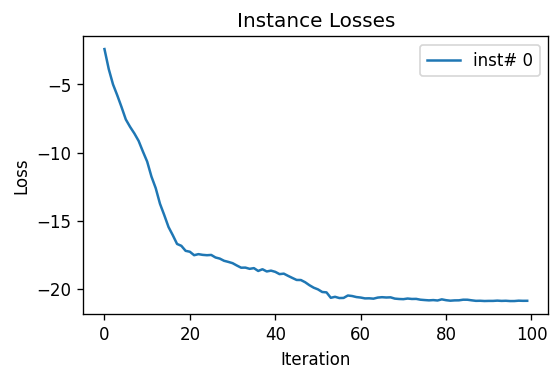

In [29]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

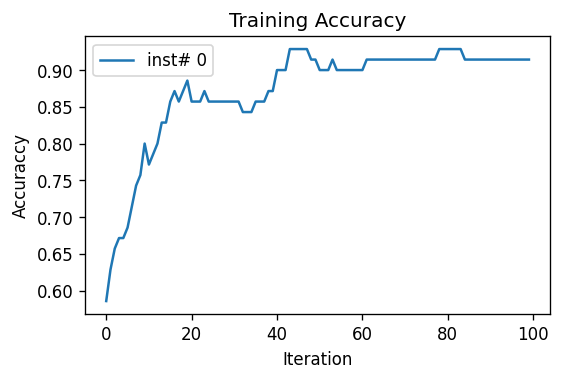

In [30]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_train).astype('float').T],
                title='Training Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

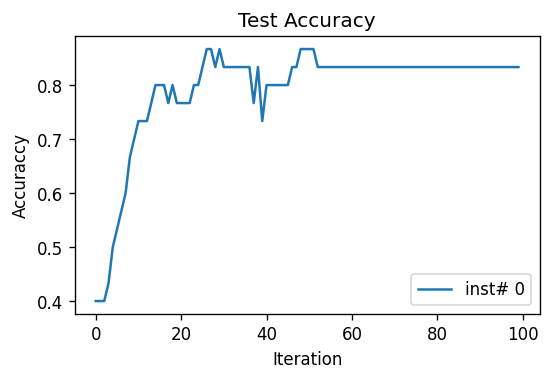

In [31]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [32]:
!pip list | grep qiskit

qiskit                        1.0.2
qiskit-aer-gpu                0.14.1
qiskit-algorithms             0.3.0
qiskit-finance                0.4.1
qiskit-machine-learning       0.7.2
qiskit-nature                 0.7.2
qiskit-optimization           0.6.1
qiskit-qasm3-import           0.4.2


In [33]:
!pip list | grep torch

torch                         2.3.0
torchaudio                    2.3.0
torchsummary                  1.5.1
torchvision                   0.18.0
